# Fine-tune Llama 2 for Sentiment Analysis

In this notebook, we will deal with **sentiment analysis on financial and economic information**. 

Sentiment analysis on financial and economic information is highly relevant for businesses as it helps to gain valuable insights into market trends, investor confidence, and consumer behavior, risk management (identifying potential reputational risks) to investment decisions (gauging the sentiment of stakeholders, investors, and the general public businesses can assess the potential success of various investment opportunities).

**The Dataset**
Scholars from the Aalto University School of Business introduced in 2014 a set of approximately 5000 sentences. This collection aimed to establish human-annotated benchmarks, serving as a standard for evaluating alternative modeling techniques. The involved annotators (16 people with adequate background knowledge on financial markets) were instructed to assess the sentences solely from the **perspective of an investor**, evaluating whether the news potentially holds a positive, negative, or neutral impact on the stock price.

The **FinancialPhraseBank dataset** is a comprehensive collection that captures the sentiments of financial news headlines from the viewpoint of a retail investor. 

Comprising two key columns, namely "Sentiment" and "News Headline," the dataset effectively classifies sentiments as either negative, neutral, or positive.

**Some key libraries used**
* <u>accelerate</u> - distributed training library for PyTorch by HuggingFace which allows to train models on multiple GPUs or CPUs in parallel (distributed configurations), which can significantly speed up training in presence of multiple GPUs.
* <u>peft</u> - by HuggingFace for efficient adaptation of pre-trained language models (PLMs) to various downstream applications without fine-tuning all the model's parameters. PEFT methods only fine-tune a small number of (extra) model parameters, thereby greatly decreasing the computational and storage costs.
* <u>bitsandbytes</u> - by Tim Dettmers, is a lightweight wrapper around CUDA custom functions, in particular 8-bit optimizers, matrix multiplication (LLM.int8()), and quantization functions. It allows to run models stored in 4-bit precision: while 4-bit bitsandbytes stores weights in 4-bits, the computation still happens in 16 or 32-bit and here any combination can be chosen (float16, bfloat16, float32, and so on).
* <u>transformers</u> - for natural language processing (NLP). It provides a number of pre-trained models for NLP tasks such as text classification, question answering, and machine translation.
* <u>trl</u> - full stack library by HuggingFace providing a set of tools to train transformer language models with Reinforcement Learning, from the Supervised Fine-tuning step (SFT), Reward Modeling step (RM) to the Proximal Policy Optimization (PPO) step.

## Installations and imports

In [3]:
!pip install -q -U "torch==2.1.2" tensorboard

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.12 requires torch<2.1,>=1.7, but you have torch 2.1.2 which is incompatible.
tensorflow 2.12.0 requires tensorboard<2.13,>=2.12, but you have tensorboard 2.19.0 which is incompatible.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 2.1.2 which is incompatible.


In [4]:
!pip install -q -U "transformers==4.36.2" "datasets==2.16.1" "accelerate==0.26.1" "bitsandbytes==0.42.0"

The code imports the os module and sets two environment variables:
* CUDA_VISIBLE_DEVICES: This environment variable tells PyTorch which GPUs to use. In this case, the code is setting the environment variable to 0, which means that PyTorch will use the first GPU.
* TOKENIZERS_PARALLELISM: This environment variable tells the Hugging Face Transformers library whether to parallelize the tokenization process. In this case, the code is setting the environment variable to false, which means that the tokenization process will not be parallelized.

In [5]:
!pip install -q -U git+https://github.com/huggingface/trl@a3c5b7178ac4f65569975efadc97db2f3749c65e
!pip install -q -U git+https://github.com/huggingface/peft@4a1559582281fc3c9283892caea8ccef1d6f5a4f

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 11.0.0 which is incompatible.
chex 0.1.82 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
cudf 23.8.0 requires pandas<1.6.0dev0,>=1.3, but you have pandas 2.0.2 which is incompatible.
cudf 23.8.0 requires protobuf<5,>=4.21, but you have protobuf 3.20.3 which is incompatible.
cuml 23.8.0 requires dask==2023.7.1, but you have dask 2023.9.0 which is incompatible.
dask-cudf 23.8.0 requires dask==2023.7.1, but you have dask 2

In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from trl import setup_chat_format
from transformers import (AutoModelForCausalLM, 
                          AutoTokenizer, 
                          BitsAndBytesConfig, 
                          TrainingArguments, 
                          pipeline, 
                          logging)
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix)
from sklearn.model_selection import train_test_split

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
print(f"pytorch version {torch.__version__}")

pytorch version 2.1.2+cu121


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"working on {device}")

working on cuda:0


In [12]:
from kaggle_secrets import UserSecretsClient
from huggingface_hub import login

user_secrets = UserSecretsClient()
login(user_secrets.get_secret("HF_TOKEN"))
hf_token = user_secrets.get_secret("HF_TOKEN")

In [13]:
2+

SyntaxError: invalid syntax (4209523232.py, line 1)

## Preparing the data and the core evaluation functions

In [23]:
# define input data and read it using pandas read_csv
import pandas as pd

filename = "/kaggle/input/sentiment-analysis-for-financial-news/all-data.csv"
df = pd.read_csv(filename, 
                 names=["sentiment", "text"],
                 encoding="utf-8", encoding_errors="replace")

In [24]:
df.shape

(4846, 2)

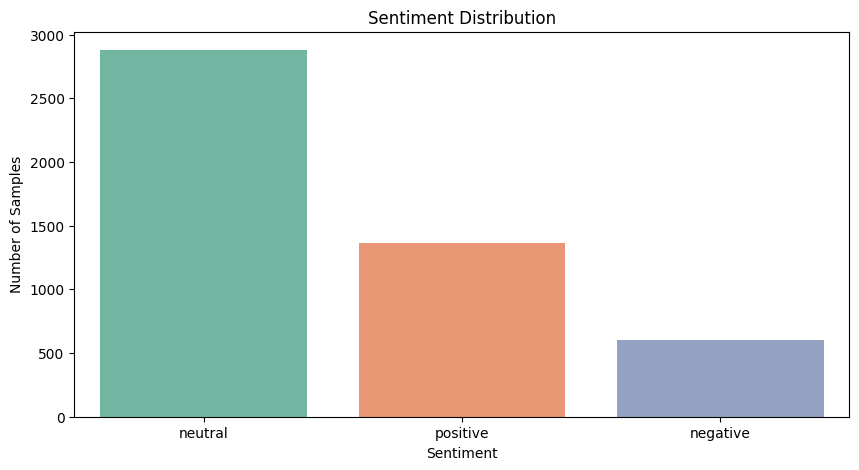

In [25]:
''' Sentiment Distribution '''
plt.figure(figsize=(10,5))
sns.countplot(data=df, 
              x='sentiment', 
              order=df['sentiment'].value_counts().index, 
              palette='Set2')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Samples')
plt.show()

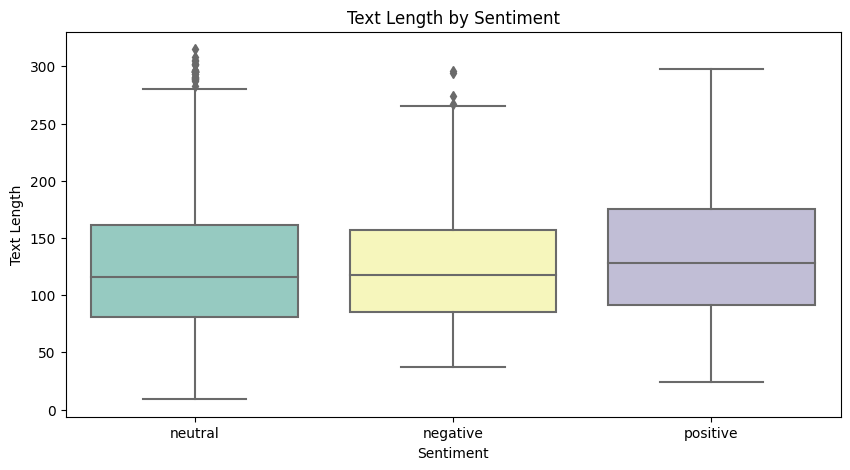

In [26]:
''' Average Text Length per Sentiment '''
df['text_length'] = df['text'].apply(len)

plt.figure(figsize=(10, 5))
sns.boxplot(data=df, 
            x='sentiment', 
            y='text_length', 
            palette='Set3')
plt.title('Text Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Text Length')
plt.show()

In [27]:
df.drop('text_length', axis=1, inplace=True)

In [28]:
df

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [29]:
# define train and test set list
X_train = list()
X_test = list()

# from each sentiment, get 300 examples in train and 300 in test
for sentiment in ["positive", "neutral", "negative"]:
    train, test  = train_test_split(df[df.sentiment==sentiment], 
                                    train_size=300,
                                    test_size=300, 
                                    random_state=42)
    X_train.append(train)  # add to train set
    X_test.append(test)    # add to test set

# and now, we will concat the three sentiments in train and test
# and, In train set, shuffle (100% of them since frac=1)
X_train = pd.concat(X_train).sample(frac=1, random_state=10)
X_test = pd.concat(X_test)

In [30]:
# let's extract whatever has not gone into train and test set
eval_idx = [idx for idx in df.index if idx not in list(X_train.index) + list(X_test.index)]
X_eval = df[df.index.isin(eval_idx)]

# grouping by sentiment and then take 50 samples from each sentiment class
X_eval = (X_eval
          .groupby('sentiment', group_keys=False)
          .apply(lambda x: x.sample(n=50, random_state=10, replace=True)))
X_train = X_train.reset_index(drop=True)

In [31]:
X_train.shape, X_test.shape, X_eval.shape

((900, 2), (900, 2), (150, 2))

In [32]:
''' Functions to generate prompt for training and testing '''
def generate_prompt(data_point):
    return f"""
            Analyze the sentiment of the news headline enclosed in square brackets, 
            determine if it is positive, neutral, or negative, and return the answer as 
            the corresponding sentiment label "positive" or "neutral" or "negative".

            [{data_point["text"]}] = {data_point["sentiment"]}
            """.strip()

def generate_test_prompt(data_point):
    return f"""
            Analyze the sentiment of the news headline enclosed in square brackets, 
            determine if it is positive, neutral, or negative, and return the answer as 
            the corresponding sentiment label "positive" or "neutral" or "negative".

            [{data_point["text"]}] = """.strip()

In [33]:
X_train = pd.DataFrame(X_train.apply(generate_prompt, axis=1), 
                       columns=["text"])

X_eval = pd.DataFrame(X_eval.apply(generate_prompt, axis=1), 
                      columns=["text"])

X_train.head()

,text
0,Analyze the sentiment of the news headline enc...
1,Analyze the sentiment of the news headline enc...
2,Analyze the sentiment of the news headline enc...
3,Analyze the sentiment of the news headline enc...
4,Analyze the sentiment of the news headline enc...


In [34]:
print(X_train['text'][0])

Analyze the sentiment of the news headline enclosed in square brackets, 
            determine if it is positive, neutral, or negative, and return the answer as 
            the corresponding sentiment label "positive" or "neutral" or "negative".

            [Mr Jortikka is president of the base metal division of Outotec Oyj in Finland and is on the executive committee of Outotec .] = neutral


In [35]:
# this is the output label
y_true = X_test.sentiment

# generating X_test by applying generate_test_prompt
X_test = pd.DataFrame(X_test.apply(generate_test_prompt, axis=1), columns=["text"])

# convert to Huggingface's Dataset
train_data = Dataset.from_pandas(X_train)
eval_data = Dataset.from_pandas(X_eval)
test_data = Dataset.from_pandas(X_test)

In [36]:
2+

SyntaxError: invalid syntax (4209523232.py, line 1)

Now, let's create a function to evaluate the results from the fine-tuned sentiment model. The function performs the following steps:
1. Maps the sentiment labels to a numerical representation, where 2 represents positive, 1 represents neutral, and 0 represents negative.
2. Calculates the accuracy of the model on the test data.
3. Generates an accuracy report for each sentiment label.
4. Generates a classification report for the model.
5. Generates a confusion matrix for the model.

In [38]:
def evaluate(y_true, y_pred):
    labels = ['positive', 'neutral', 'negative']
    mapping = {'positive': 2, 
               'neutral': 1, 'none':1, 
               'negative': 0}
    def map_func(x):
        '''
        this is a helper function to convert labels to numeric form.
        If a label is not found, 1 is returned
        '''
        return mapping.get(x, 1)

    # vectorize allows to apply a Python function element-wise to arrays, 
    # effectively "vectorizing" the function
    vectorize_func = np.vectorize(map_func)
    y_true = vectorize_func(y_true)
    y_pred = vectorize_func(y_pred)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    print(f'Accuracy: {accuracy:.3f}')
    
    # Generate accuracy report
    unique_labels = set(y_true)  # Get unique labels
    
    for label in unique_labels:
        # find indices where true label is equal to current class label
        label_indices = [i for i in range(len(y_true)) 
                         if y_true[i] == label]

        # get y_true and y_pred values only for that label. 
        # This will be used to calculate per-class accuracy.
        label_y_true = [y_true[i] for i in label_indices]
        label_y_pred = [y_pred[i] for i in label_indices]
        accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {label}: {accuracy:.3f}')
        
    # Generate classification report
    class_report = classification_report(y_true=y_true, y_pred=y_pred)
    print('\nClassification Report:')
    print(class_report)
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0, 1, 2])
    print('\nConfusion Matrix:')
    print(conf_matrix)

## Testing the model without fine-tuning

Next we need to take care of the model, which is a 7b-hf (7 billion parameters, no RLHF, in the HuggingFace compatible format), loading from Kaggle models and quantization.

Model loading and quantization:

* First the code loads the Llama-2 language model from the Hugging Face Hub.
* Then the code gets the float16 data type from the torch library. This is the data type that will be used for the computations.
* Next, it creates a BitsAndBytesConfig object with the following settings:
    1. load_in_4bit: Load the model weights in 4-bit format.
    2. bnb_4bit_quant_type: Use the "nf4" quantization type. 4-bit NormalFloat (NF4), is a new data type that is information theoretically optimal for normally distributed weights.
    3. bnb_4bit_compute_dtype: Use the float16 data type for computations.
    4. bnb_4bit_use_double_quant: Do not use double quantization (reduces the average memory footprint by quantizing also the quantization constants and saves an additional 0.4 bits per parameter.).
* Then the code creates a AutoModelForCausalLM object from the pre-trained Llama-2 language model, using the BitsAndBytesConfig object for quantization.
* After that, the code disables caching for the model.
* Finally the code sets the pre-training token probability to 1.

Tokenizer loading:

* First, the code loads the tokenizer for the Llama-2 language model.
* Then it sets the padding token to be the end-of-sequence (EOS) token.
* Finally, the code sets the padding side to be "right", which means that the input sequences will be padded on the right side. This is crucial for correct padding direction (this is the way with Llama 2).

In [ ]:
from kaggle_secrets import UserSecretsClient
from huggingface_hub import login

user_secrets = UserSecretsClient()
login(user_secrets.get_secret("HF_TOKEN"))
hf_token = user_secrets.get_secret("HF_TOKEN")

In [ ]:
from huggingface_hub import whoami

info = whoami()
info

In [ ]:
# define path to pre-trained model in huggingface
# model_name = "../input/llama-2/pytorch/7b-hf/1"
model_name = "meta-llama/Llama-2-7b-hf"

# for faster computation and less memory compared to float32
compute_dtype = getattr(torch, "float16")

# Configure 4-bit quantization using bitsandbytes
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                      # Load the model in 4-bit mode using bitsandbytes
    bnb_4bit_quant_type="nf4",              #  Use NF4 (Normal Float 4) quantization, optimized for LLMs
    bnb_4bit_compute_dtype=compute_dtype,   # Use float16 for matrix multiplications
    bnb_4bit_use_double_quant=True,         # Apply double quantization for further memory efficiency
)

# load model from the defined checkpoint
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map=device,
    torch_dtype=compute_dtype,
    quantization_config=bnb_config, 
    use_auth_token=hf_token
)

model.config.use_cache = False    # Disables caching of key-value pairs during generation
model.config.pretraining_tp = 1   # Sets tensor parallelism factor to 1 (no tensor parallelism across GPUs)

tokenizer = AutoTokenizer.from_pretrained(model_name, 
                                          trust_remote_code=True,
                                          use_auth_token=hf_token
                                         )
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

model, tokenizer = setup_chat_format(model, tokenizer)

In [ ]:
model

In the next cell, we set a function for predicting the sentiment of a news headline using the Llama-2 language model. The function takes three arguments:

test: A Pandas DataFrame containing the news headlines to be predicted.
model: The pre-trained Llama-2 language model.
tokenizer: The tokenizer for the Llama-2 language model.

The function works as follows:

1. For each news headline in the test DataFrame:
    * Create a prompt for the language model, which asks it to analyze the sentiment of the news headline and return the corresponding sentiment label.
    * Use the pipeline() function from the Hugging Face Transformers library to generate text from the language model, using the prompt.
    * Extract the predicted sentiment label from the generated text.
    * Append the predicted sentiment label to the y_pred list.
2. Return the y_pred list.

The pipeline() function from the Hugging Face Transformers library is used to generate text from the language model. The task argument specifies that the task is text generation. The model and tokenizer arguments specify the pre-trained Llama-2 language model and the tokenizer for the language model. The max_new_tokens argument specifies the maximum number of new tokens to generate. The temperature argument controls the randomness of the generated text. A lower temperature will produce more predictable text, while a higher temperature will produce more creative and unexpected text.

The if statement checks if the generated text contains the word "positive". If it does, then the predicted sentiment label is "positive". Otherwise, the if statement checks if the generated text contains the word "negative". If it does, then the predicted sentiment label is "negative". Otherwise, the if statement checks if the generated text contains the word "neutral". If it does, then the predicted sentiment label is "neutral.

In [ ]:
def predict(test, model, tokenizer):
    y_pred = []
    # create a Hugging Face pipeline for text generation
    pipe = pipeline(task="text-generation", 
                    model=model, 
                    tokenizer=tokenizer, 
                    max_new_tokens = 1, 
                    do_sample=False,
                    #temperature = 0.0   # should be > 0 if do_sample = False (greedy decoding)
                   )
    for i in tqdm(range(len(X_test))):
        prompt = X_test.iloc[i]["text"]
        result = pipe(prompt)

        # extract the part after the equal sign (=) from the generated text
        answer = result[0]['generated_text'].split("=")[-1]
        if "positive" in answer:
            y_pred.append("positive")
        elif "negative" in answer:
            y_pred.append("negative")
        elif "neutral" in answer:
            y_pred.append("neutral")
        else:
            y_pred.append("none")
    return y_pred

At this point, we are ready to test the Llama 2 7b-hf model and see how it performs on our problem without any fine-tuning. This allows us to get insights on the model itself and establish a baseline.

In [ ]:
y_pred = predict(test, model, tokenizer)

In the following cell, we evaluate the results. There is little to be said, it is performing really terribly because the 7b-hf model tends to just predict a neutral sentiment and seldom it detects positive or negative sentiment.

In [ ]:
evaluate(y_true, y_pred)

In [ ]:
''' Adding a little optimization '''
from transformers import pipeline
from tqdm import tqdm

def predict_optimized(test, model, tokenizer):
    # Setup pipeline once
    pipe = pipeline(
        task="text-generation", 
        model=model, 
        tokenizer=tokenizer, 
        max_new_tokens=1, 
        do_sample=False
    )

    # Create all prompts
    prompts = test["text"].tolist()

    # Run pipeline in batch mode (efficient!)
    results = pipe(prompts, batch_size=8)  # we can adjust batch size as per GPU

    # Extract predictions
    y_pred = []
    for output in results:
        answer = output['generated_text'].split("=")[-1].lower().strip()
        if "positive" in answer:
            y_pred.append("positive")
        elif "negative" in answer:
            y_pred.append("negative")
        elif "neutral" in answer:
            y_pred.append("neutral")
        else:
            y_pred.append("none")

    return y_pred


## Fine-tuning

In the next cell we set everything ready for the fine-tuning. We configures and initializes a Simple Fine-tuning Trainer (SFTTrainer) for training a large language model using the Parameter-Efficient Fine-Tuning (PEFT) method, which should save time as it operates on a reduced number of parameters compared to the model's overall size. The PEFT method focuses on refining a limited set of (additional) model parameters, while keeping the majority of the pre-trained LLM parameters fixed. This significantly reduces both computational and storage expenses. Additionally, this strategy addresses the challenge of catastrophic forgetting, which often occurs during the complete fine-tuning of LLMs.

PEFTConfig:

The peft_config object specifies the parameters for PEFT. The following are some of the most important parameters:

* lora_alpha: The learning rate for the LoRA update matrices.
* lora_dropout: The dropout probability for the LoRA update matrices.
* r: The rank of the LoRA update matrices.
* bias: The type of bias to use. The possible values are none, additive, and learned.
* task_type: The type of task that the model is being trained for. The possible values are CAUSAL_LM and MASKED_LM.

TrainingArguments:

The training_arguments object specifies the parameters for training the model. The following are some of the most important parameters:

* output_dir: The directory where the training logs and checkpoints will be saved.
* num_train_epochs: The number of epochs to train the model for.
* per_device_train_batch_size: The number of samples in each batch on each device.
* gradient_accumulation_steps: The number of batches to accumulate gradients before updating the model parameters.
* optim: The optimizer to use for training the model.
* save_steps: The number of steps after which to save a checkpoint.
* logging_steps: The number of steps after which to log the training metrics.
* learning_rate: The learning rate for the optimizer.
* weight_decay: The weight decay parameter for the optimizer.
* fp16: Whether to use 16-bit floating-point precision.
* bf16: Whether to use BFloat16 precision.
* max_grad_norm: The maximum gradient norm.
* max_steps: The maximum number of steps to train the model for.
* warmup_ratio: The proportion of the training steps to use for warming up the learning rate.
* group_by_length: Whether to group the training samples by length.
* lr_scheduler_type: The type of learning rate scheduler to use.
* report_to: The tools to report the training metrics to.
* evaluation_strategy: The strategy for evaluating the model during training.

SFTTrainer:

The SFTTrainer is a custom trainer class from the TRL library. It is used to train large language models (also using the PEFT method).

The SFTTrainer object is initialized with the following arguments:

* model: The model to be trained.
* train_dataset: The training dataset.
* eval_dataset: The evaluation dataset.
* peft_config: The PEFT configuration.
* dataset_text_field: The name of the text field in the dataset.
* tokenizer: The tokenizer to use.
* args: The training arguments.
* packing: Whether to pack the training samples.
* max_seq_length: The maximum sequence length.

Once the SFTTrainer object is initialized, it can be used to train the model by calling the train() method

In [ ]:
'''
sets up parameter-efficient fine-tuning (PEFT) using LoRA (Low-Rank Adaptation) 
on a decoder-only causal language model.

PEFT is a set of techniques designed to fine-tune large pre-trained models 
using much fewer trainable parameters. PEFT techniques freeze most of the model 
and only train a small part.

LoRA (Low-Rank Adaptation) is a popular PEFT method introduced by Microsoft Research in 2021.
Instead of updating the full weight matrix W in a neural network layer, 
LoRA freezes W and learns two small matrices A and B.

LoRA can be imagined like compressing a file into a ZIP (down-projection) and 
then unzipping it (up-projection) — but only train the ZIP and UNZIP process, 
not the entire original file.
'''
# define the output directory - where the model checkpoints will be saved
output_dir="trained_weigths"

# This config tells the model how to apply LoRA, 
# which injects trainable low-rank adapters into the model's linear layers, 
# allowing fine-tuning without updating all weights
peft_config = LoraConfig(
        lora_alpha=16, 
        lora_dropout=0.1,
        r=64,
        bias="none",
        target_modules="all-linear",
        task_type="CAUSAL_LM",
)

training_arguments = TrainingArguments(
    output_dir=output_dir,                    # directory to save and repository id
    num_train_epochs=3,                       # number of training epochs
    per_device_train_batch_size=1,            # batch size per device during training
    gradient_accumulation_steps=8,            # number of steps before performing a backward/update pass
    gradient_checkpointing=True,              # use gradient checkpointing to save memory
    optim="paged_adamw_32bit",
    save_steps=0,
    logging_steps=25,                         # log every 10 steps
    learning_rate=2e-4,                       # learning rate, based on QLoRA paper
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=0.3,                        # max gradient norm based on QLoRA paper
    max_steps=-1,
    warmup_ratio=0.03,                        # warmup ratio based on QLoRA paper
    group_by_length=True,
    lr_scheduler_type="cosine",               # use cosine learning rate scheduler
    report_to="tensorboard",                  # report metrics to tensorboard
    evaluation_strategy="epoch"               # save checkpoint every epoch
)

trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=peft_config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    max_seq_length=1024,
    packing=False,
    dataset_kwargs={
        "add_special_tokens": False,
        "append_concat_token": False,
    }
)

The following code will train the model using the trainer.train() method and then save the trained model to the trained-model directory. Using The standard GPU P100 offered by Kaggle, the training should be quite fast.

In [ ]:
# Train model
trainer.train()

In [ ]:
# Save trained model and tokenizer for later usage
trainer.save_model()
tokenizer.save_pretrained(output_dir)

<img src = attachment:9ffda96b-3f85-44e4-b03b-f4f214864d75.png width=400>
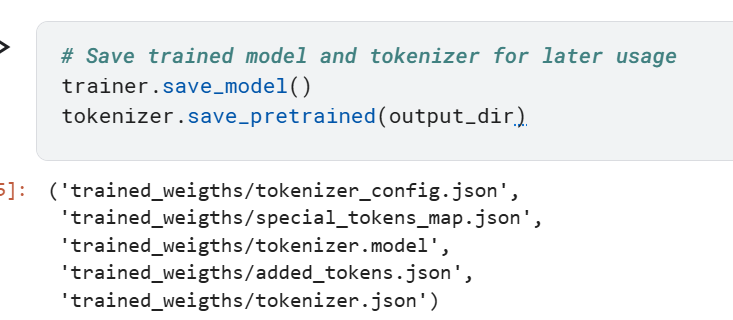

Afterwards, loading the TensorBoard extension and start TensorBoard, pointing to the logs/runs directory, which is assumed to contain the training logs and checkpoints for your model, will allow you to understand how the models fits during the training.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/runs

## Saving model to disk for later usage

At this point, in order to demonstrate how to re-utilize the model, we reload it from the disk and merge it with the original LLama model.

In fact, when working with QLoRA, we exclusively train adapters instead of the entire model. So, when you save the model during training, you're only preserving the adapter weights, not the entire model. If you want to save the full model for easier use with Text Generation Inference, you can merge the adapter weights into the model weights using the merge_and_unload method. Then, you can save the model using the save_pretrained method. This will create a default model that's ready for inference tasks.

Before proceeding, we first remove the previous model and clean up the memory from various objects we won't use anymore.

In [ ]:
import gc

del [model, tokenizer, peft_config, trainer, train_data, eval_data, bnb_config, training_arguments]
del [df, X_train, X_eval]
del [TrainingArguments, SFTTrainer, LoraConfig, BitsAndBytesConfig]

In [ ]:
import gc
for _ in range(100):
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
!nvidia-smi

Then we can proceed to merging the weights and we will be using the merged model for our testing purposes.

In [ ]:
!ls /kaggle/input/llama2-finetuned-sentiment-lora/kaggle/working/trained_weigths

In [ ]:
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer

model_name = 'meta-llama/Llama-2-7b-hf'

finetuned_model = "/kaggle/input/llama2-finetuned-sentiment-lora/kaggle/working/trained_weigths/"
compute_dtype = getattr(torch, "float16")
tokenizer = AutoTokenizer.from_pretrained(model_name,
                                         use_auth_token = hf_token)

model = AutoPeftModelForCausalLM.from_pretrained(
     finetuned_model,
     torch_dtype=compute_dtype,
     return_dict=False,
     low_cpu_mem_usage=True,
     device_map=device,
)

In [ ]:
model

In [ ]:
# clear gpu before merging
torch.cuda.empty_cache()

In [ ]:
merged_model = model.merge_and_unload()

In [ ]:
merged_model.save_pretrained("./merged_model",
                             safe_serialization=True, 
                             max_shard_size="2GB")
tokenizer.save_pretrained("./merged_model")

## Testing

The following code will first predict the sentiment labels for the test set using the predict() function. Then, it will evaluate the model's performance on the test set using the evaluate() function. The result now should be impressive with an overall accuracy of over 0.8 and high accuracy, precision and recall for the single sentiment labels. The prediction of the neutral label can still be improved, yet it is impressive how much could be done with little data and some fine-tuning.

In [37]:
y_pred = predict(test_data, merged_model, tokenizer)

100%|██████████| 900/900 [03:50<00:00,  3.91it/s]


NameError: name 'evaluate' is not defined

In [39]:
evaluate(y_true, y_pred)

Accuracy: 0.853
Accuracy for label 0: 0.920
Accuracy for label 1: 0.840
Accuracy for label 2: 0.800

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       300
           1       0.76      0.84      0.80       300
           2       0.86      0.80      0.83       300

    accuracy                           0.85       900
   macro avg       0.86      0.85      0.85       900
weighted avg       0.86      0.85      0.85       900


Confusion Matrix:
[[276  22   2]
 [ 11 252  37]
 [  1  59 240]]


The following code will create a Pandas DataFrame called evaluation containing the text, true labels, and predicted labels from the test set. This is expectially useful for understanding the errors that the fine-tuned model makes, and gettting insights on how to improve the prompt.

In [40]:
evaluation = pd.DataFrame({'text': X_test["text"], 
                           'y_true':y_true, 
                           'y_pred': y_pred},
                         )
evaluation.to_csv("test_predictions.csv", index=False)

In [41]:
evaluation

,text,y_true,y_pred
567,Analyze the sentiment of the news headline enc...,positive,positive
1752,Analyze the sentiment of the news headline enc...,positive,positive
995,Analyze the sentiment of the news headline enc...,positive,neutral
601,Analyze the sentiment of the news headline enc...,positive,positive
568,Analyze the sentiment of the news headline enc...,positive,neutral
...,...,...,...
4219,Analyze the sentiment of the news headline enc...,negative,negative
4814,Analyze the sentiment of the news headline enc...,negative,negative
4059,Analyze the sentiment of the news headline enc...,negative,negative
4720,Analyze the sentiment of the news headline enc...,negative,negative


The evaluation results are indeed good when compared to simpler benchmarks such as a CONV1D + bidirectional LSTM based model () such as: https://www.kaggle.com/code/lucamassaron/lstm-baseline-for-sentiment-analysis

Here are the results of the baseline model:

Accuracy: 0.623
Accuracy for label 0: 0.620
Accuracy for label 1: 0.590
Accuracy for label 2: 0.660

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.62      0.69       300
           1       0.61      0.59      0.60       300
           2       0.53      0.66      0.59       300

    accuracy                           0.62       900
   macro avg       0.64      0.62      0.63       900
weighted avg       0.64      0.62      0.63       900


Confusion Matrix:

[[186  39  75]\
 [ 23 177 100]\
 [ 27  75 198]]
 

With this testing, the fine-tuning of Llama 2 has reached its conclusion. Dont't forget to upvote if you find the notebook useful for your projects or work! 